# TP1 — Part 3: CNNs + Data Augmentation on MNIST (Rotation & Translation)

**Course:** Deep Learning for Image Analysis / Computer Vision  
**Goal:** Train a **CNN** on MNIST, **inspect its layers**, and show how **data augmentation** (rotation + translation) can improve robustness.

In Part 2, we used an MLP and **flattened** images into vectors.  
In Part 3, we use **CNNs** to exploit spatial structure **(1, 28, 28)** and we test a key idea in vision:  
> If we train with rotated/translated images, the model generalizes better to these transformations.

---
## What you will do
1. Train a baseline CNN on MNIST (no augmentation)
2. Train the same CNN with **RandomAffine** augmentation (rotation + translation)
3. Compare test accuracy on:
   - **standard MNIST test**
   - **transformed MNIST test** (rotated/translated)
---


## 0) Setup (Colab GPU)

In Colab: **Runtime → Change runtime type → GPU**  
Then run the cell below.


In [55]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
if torch.mps.is_available():
    print(torch.get_num_threads(), "GPU threads.")


Using device: mps
4 GPU threads.


## 1) Imports

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


## 2) Data: MNIST + Augmentations

We will create **four** dataset variants:

1. **Train (no aug)**: standard MNIST training set  
2. **Train (aug)**: MNIST with *rotation + translation* 
3. **Test (standard)**: standard MNIST test set  
4. **Test (transformed)**: MNIST test set **with the same types of transforms** (to evaluate robustness)

### Augmentation used
- Rotation: up to ±35 degrees
- Translation: up to 30% of the image size

This simulates real-world variation (digits rarely appear perfectly centered).


In [57]:
torch.manual_seed(0)

# Standard transform
tfm_standard = transforms.ToTensor()

# Augmentation: rotation + translation (applied during training)
tfm_aug = transforms.Compose([
   # Todo tansformations to be applied
    transforms.RandomAffine(
        degrees=35,
        translate=(.3, .3)
    ),
    transforms.ToTensor()
])

# "Transformed test" to measure robustness to these changes
tfm_test_transformed = transforms.Compose([
    #Todo same transformations as above
    transforms.RandomAffine(
        degrees=35,
        translate=(.3, .3)
    ),
    transforms.ToTensor()
])

# Datasets
train_noaug = torchvision.datasets.MNIST(
    root="./data",
    download=True,
    train=True,
    transform=tfm_standard
) # TDDO: import mnist train without augmentation 
train_aug = torchvision.datasets.MNIST(
    root="./data",
    download=True,
    train=True,
    transform=tfm_aug
)# TDDO import mnist with augmentation

test_std = torchvision.datasets.MNIST(
    root="./data",
    download=True,
    train=False,
    transform=tfm_standard
) # TDDO: import mnist test without augmentation 

test_trans = torchvision.datasets.MNIST( 
    root="./data",
    download=True,
    train=False,
    transform=tfm_test_transformed
)# TDDO: import mnist test without augmentation 

len(train_noaug), len(train_aug), len(test_std), len(test_trans)


(60000, 60000, 10000, 10000)

### Quick visualization (standard vs augmented)

If augmentation is working, you should see digits slightly rotated and shifted.


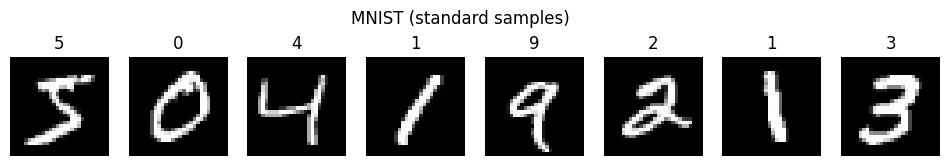

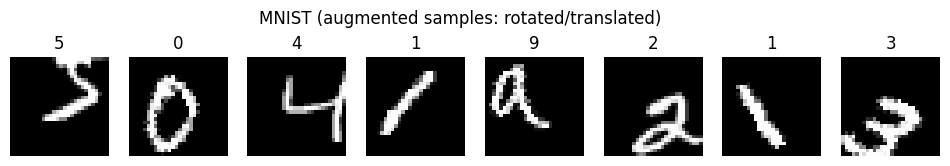

In [58]:
def show_samples(dataset, title, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_noaug, "MNIST (standard samples)")
show_samples(train_aug, "MNIST (augmented samples: rotated/translated)")


## 3) DataLoaders

We'll use mini-batches. If you run out of memory, reduce `batch_size`.


In [59]:
batch_size = 128

train_loader_noaug = DataLoader(train_noaug, batch_size=batch_size, shuffle=True) # TDDO : create the dataloader : we saw it in the first part
train_loader_aug   = DataLoader(train_aug, batch_size=batch_size, shuffle=True) # TDDO 

test_loader_std    = DataLoader(test_std, batch_size=batch_size, shuffle=True) # TDDO 
test_loader_trans  = DataLoader(test_trans, batch_size=batch_size, shuffle=True) # TDDO 


## 4) CNN model

A simple CNN for MNIST:

- Conv(1→16) + ReLU + MaxPool
- Conv(16→32) + ReLU + MaxPool
- Flatten
- FC(32×7×7 → 128) + ReLU
- FC(128 → 10)

This is intentionally small so it trains quickly on Colab.


In [60]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)# TDDO :  number of classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 5) Training & evaluation utilities

We use:
- Loss: `CrossEntropyLoss` (10 classes)
- Optimizer: `Adam`

We'll train the same architecture twice:
1) on standard MNIST (no aug)
2) on augmented MNIST (rotation + translation)


In [61]:
criterion = nn.CrossEntropyLoss()# TODO loss function 

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
       # TDDO : carete the training loop
       images = images.to(device)
       labels = labels.to(device)
       
       # Zero the gradients
       optimizer.zero_grad()

       # forward pass
       preds = model(images)

       # Compute the loss on the batch
       loss = criterion(preds, labels)

       # Backpropagation phase
       loss.backward()

       # Step of optimization with Adam
       optimizer.step()

       # Disable tracking of computations to compute correct guesses
       with torch.no_grad():
           # Total number of images seen update
           total += labels.size(0)

           # Total loss update
           total_loss += loss.item()

           # Transformation of logits into class labels
           _, pred_labels = torch.max(preds, dim=1)

           # Number of correct guesses
           correct += (pred_labels == labels).sum().item()


    return total_loss / len(loader), correct / total

# TODO:  before evaluating the model
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in loader:
        
        # TDDO evaluation loop
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
           preds = model(images)

            # Total number of images seen update
           total += labels.size(0)

           # Total loss update
           total_loss += criterion(preds, labels).item()

           # Transformation of logits into class labels
           _, pred_labels = torch.max(preds, dim=1)

           # Number of correct guesses
           correct += (pred_labels == labels).sum().item()
            

    return total_loss / len(loader), correct / total


## 6) Train baseline CNN (no augmentation)

You can increase `epochs` if you wants


In [62]:
def train_model(train_loader, epochs=3, lr=1e-3):
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc = evaluate(model, test_loader_std)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(f"Epoch {epoch}/{epochs} | train_loss={tr_loss:.4f} train_acc={tr_acc:.3f} | test_std_acc={va_acc:.3f}")
    return model, history

epochs = 3

# List of learning rates : 20 lr between 1e-5 and 1e-2
lrs = torch.linspace(1e-5, 1e-2, 20)

# Test this list of learning rates and choose the best model
cnns, hists = [], []

for lr in lrs:
    print(f"{'lr='+str(lr.item()):-^100}")
    cnn_noaug, hist_noaug = train_model(train_loader_noaug, lr=lr)# TDDO : train_model on the non-augmented data, choose a good learning rate
    cnns.append(cnn_noaug), hists.append(hist_noaug)
    print(hist_noaug)


--------------------------------------lr=9.999999747378752e-06--------------------------------------
Epoch 1/3 | train_loss=2.2216 train_acc=0.458 | test_std_acc=0.704
Epoch 2/3 | train_loss=1.8676 train_acc=0.732 | test_std_acc=0.781
Epoch 3/3 | train_loss=1.3357 train_acc=0.784 | test_std_acc=0.807
{'train_loss': [2.2215676821116954, 1.867596083104229, 1.3357381018748415], 'train_acc': [0.4583333333333333, 0.7323333333333333, 0.7835166666666666], 'val_loss': [2.093047317070297, 1.5921971692314631, 1.079626587372792], 'val_acc': [0.704, 0.7815, 0.807]}
--------------------------------------lr=0.0005357895279303193--------------------------------------
Epoch 1/3 | train_loss=0.4144 train_acc=0.889 | test_std_acc=0.964
Epoch 2/3 | train_loss=0.1049 train_acc=0.969 | test_std_acc=0.979
Epoch 3/3 | train_loss=0.0701 train_acc=0.979 | test_std_acc=0.981
{'train_loss': [0.41440158911637154, 0.10492575827882743, 0.07006972092888884], 'train_acc': [0.8887166666666667, 0.9685333333333334, 0.97

> From these results, we choose the best model in terms of validation accuracy. Indeed, we want our model to generalize well on new data. The train accuracy is not really relevant in choosing a model as it only let us know if the model is learning well.

In [63]:
cnn_noaug, hist_noaug = sorted(zip(cnns, hists), key=lambda elem: elem[1]['val_acc'][-1], reverse=True)[0]
print("Best model selected: ")
hist_noaug

Best model selected: 


{'train_loss': [0.15740429207897072, 0.04847522015109468, 0.03535477045006546],
 'train_acc': [0.9491333333333334, 0.9853166666666666, 0.9892666666666666],
 'val_loss': [0.05037601289775553, 0.03950143024572938, 0.033227956961380624],
 'val_acc': [0.9835, 0.9873, 0.9899]}

## 7) Train CNN with augmentation (rotation + translation)

Augmentation often makes training harder (samples are more varied), but increases robustness.


In [64]:
# Test this list of learning rates and choose the best model
cnns_aug, hists_aug = [], []

for lr in lrs:
    print(f"{'lr='+str(lr.item()):-^100}")
    cnn_aug, hist_aug = train_model(train_loader_aug, lr=lr)# TDDO : train_model on the augmented data, choose a good learning rate
    cnns_aug.append(cnn_aug), hists_aug.append(hist_aug)
    print(hist_aug)

--------------------------------------lr=9.999999747378752e-06--------------------------------------
Epoch 1/3 | train_loss=2.2982 train_acc=0.117 | test_std_acc=0.176
Epoch 2/3 | train_loss=2.2726 train_acc=0.227 | test_std_acc=0.267
Epoch 3/3 | train_loss=2.2145 train_acc=0.245 | test_std_acc=0.340
{'train_loss': [2.298203562876817, 2.272645825770364, 2.214478353447497], 'train_acc': [0.1169, 0.22681666666666667, 0.24491666666666667], 'val_loss': [2.285200176359732, 2.233792772775964, 2.1389854467367826], 'val_acc': [0.1757, 0.2671, 0.3404]}
--------------------------------------lr=0.0005357895279303193--------------------------------------
Epoch 1/3 | train_loss=1.6237 train_acc=0.438 | test_std_acc=0.817
Epoch 2/3 | train_loss=0.8680 train_acc=0.728 | test_std_acc=0.908
Epoch 3/3 | train_loss=0.6473 train_acc=0.802 | test_std_acc=0.918
{'train_loss': [1.6236826228434598, 0.8680476684814323, 0.6472697534413734], 'train_acc': [0.43771666666666664, 0.7282666666666666, 0.8019], 'val_lo

> Using the same rule, we select the model with best validation accuracy.

In [65]:
# Select the best model in mean
cnn_aug, hist_aug = sorted(zip(cnns_aug, hists_aug), key=lambda elem: elem[1]['val_acc'][-1], reverse=True)[0]
hist_aug

{'train_loss': [0.9879211564816391, 0.3534856519973609, 0.267602055581775],
 'train_acc': [0.6650666666666667, 0.8918333333333334, 0.9162333333333333],
 'val_loss': [0.23940817974036252, 0.13046171259182163, 0.10942126586561716],
 'val_acc': [0.9273, 0.9579, 0.9657]}

## 8) Evaluate robustness

We evaluate both models on:
- Standard MNIST test set
- Transformed MNIST test set (rotated/translated)

A robust model should lose **less accuracy** on the transformed test set.


In [66]:
noaug_std_loss, noaug_std_acc = evaluate(cnn_noaug, test_loader_std) # TDDO : evaluate on standard test set
noaug_tr_loss,  noaug_tr_acc  = evaluate(cnn_noaug, test_loader_trans) # TODO
aug_std_loss,   aug_std_acc   = evaluate(cnn_aug, test_loader_std) # TODO
aug_tr_loss,    aug_tr_acc    = evaluate(cnn_aug, test_loader_trans) # TODO
print("=== Baseline CNN (no augmentation) ===")
print(f"Test (standard):    acc={noaug_std_acc:.3f}")
print(f"Test (transformed): acc={noaug_tr_acc:.3f}")
print()
print("=== CNN trained with augmentation ===")
print(f"Test (standard):    acc={aug_std_acc:.3f}")
print(f"Test (transformed): acc={aug_tr_acc:.3f}")


=== Baseline CNN (no augmentation) ===
Test (standard):    acc=0.990
Test (transformed): acc=0.244

=== CNN trained with augmentation ===
Test (standard):    acc=0.966
Test (transformed): acc=0.930


### Plot training curves (optional)

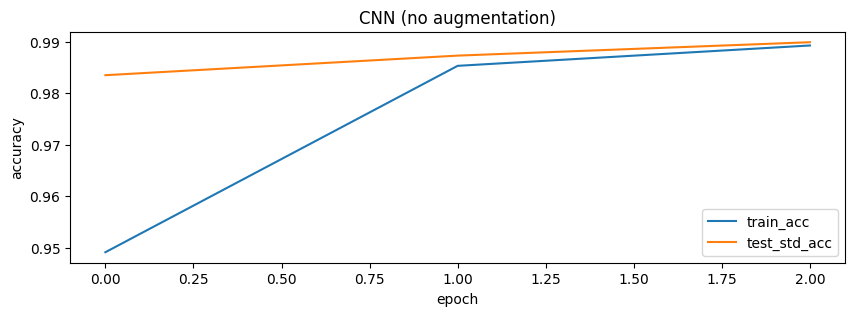

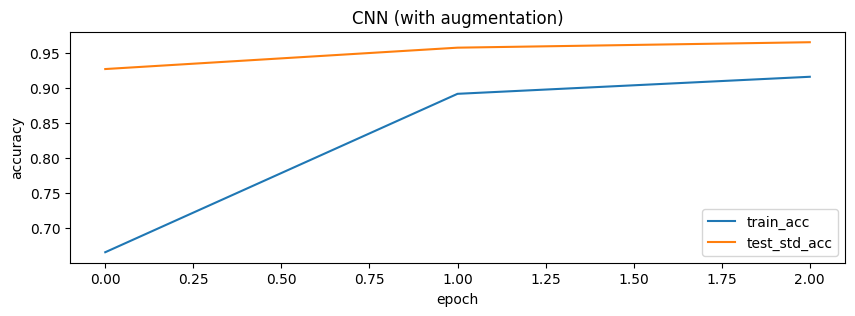

In [67]:
def plot_hist(hist, title):
    plt.figure(figsize=(10, 3))
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="test_std_acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

plot_hist(hist_noaug, "CNN (no augmentation)")
plot_hist(hist_aug, "CNN (with augmentation)")


## 9) Visualizing CNN layers

We will look at:
1. **First-layer convolution filters** (weights of Conv1)
2. **Feature maps (activations)** for a single image

This helps you *see* what the CNN learns.


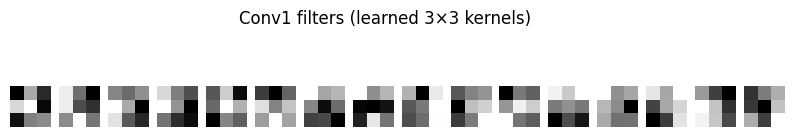

In [68]:
def show_conv1_filters(model, max_filters=16):
    conv1 = None
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            conv1 = layer
            break
    W = conv1.weight.detach().cpu()  # (out_channels, in_channels, kH, kW)

    n = min(W.shape[0], max_filters)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(W[i, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Conv1 filters (learned 3×3 kernels)")
    plt.show()

show_conv1_filters(cnn_aug)


### Feature maps (activations)

We take **one test image**, pass it through the CNN, and visualize outputs after each convolution layer.


In [69]:
@torch.no_grad()
def get_activations(model, x):
    activations = []
    cur = x
    for layer in model.features:
        cur = layer(cur)
        if isinstance(layer, nn.Conv2d):
            activations.append(cur.detach().cpu())
    return activations

# One sample from the standard test set
img, label = test_std[0]
x = img.unsqueeze(0).to(device)

acts = get_activations(cnn_aug, x)

print("Label:", label)
print("Activation shapes:", [a.shape for a in acts])


Label: 7
Activation shapes: [torch.Size([1, 16, 28, 28]), torch.Size([1, 32, 14, 14])]


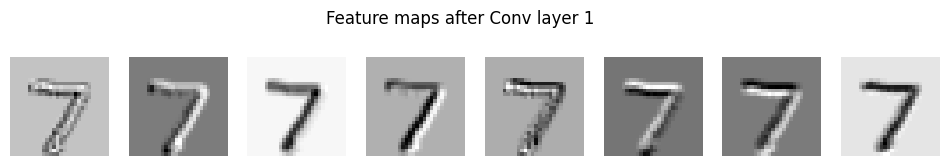

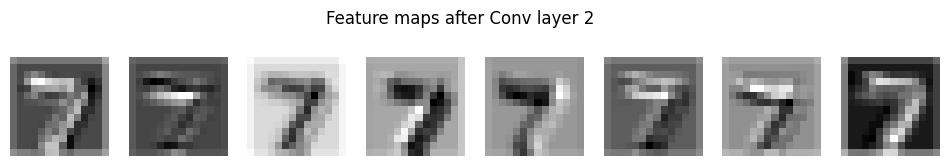

In [70]:
def show_feature_maps(activation, title, max_maps=8):
    C = activation.shape[1]
    n = min(C, max_maps)
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(activation[0, i], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

for idx, act in enumerate(acts, start=1):
    show_feature_maps(act, f"Feature maps after Conv layer {idx}", max_maps=8)


## 10) Final reflection 

1. Compare **standard test accuracy** vs **transformed test accuracy** for both models. What do you notice?

> The baseline model is very accurate on the standard test set (99%) whereas it is poor on the augmented set (only 24.4%). The CNN trained with augmentation yields a lower accuracy on the standard test set (96.6%) wheras is as very good results on the augmented set (93%). We notice that the first model performed a sort of overfitting in the sense it has perfectly learned some spatial patterns but is not able to generalize to the same forms translated and rotated. We also pinpoint that the second model has 2.4 points of percentage less than the first one on the standard test set. It is probable that this result is a consequence of the bias-variance tradeoff : the spatial invariance we inserted in the model increased the bias but decreased the model variance as it is less sensitive to small variations of the train set. 

=== Baseline CNN (no augmentation) ===
Test (standard):    acc=0.990
Test (transformed): acc=0.244

=== CNN trained with augmentation ===
Test (standard):    acc=0.966
Test (transformed): acc=0.930

2. Why does augmentation help on the transformed test set?

> Augmentation helps the model to focus on local structures rather than on spatial coordinates. Indeed, it forces it to learn features that are translation-invariant. Instead of associating a digit with fixed pixel coordinates, the network is able to recognize the relative positions of pixels. 

3. Do we always expect augmentation to improve standard test accuracy? Why/why not?

> It may not be relevant in every scenario. A classic example is a game board such as Chess or Go. Indeed, those games require the model to learn from neighborhoods of pixels, but a dataset augmentation as we did here has no sense in such scenario. Moreover, some augmentations may have the contrary effect we expect. For instance, in our case, if we allow rotations to have a degree greater than 180 degrees then a 6 may become a 9. It may lead to label inconsistency in the dataset where two examples labeled 6 and 9 may have the same image.

**Conclusion:** In the next LAB(2), we will go deeper into CNN architectures, and you should see further accuracy improvements.
